In [1]:
import numpy as np
import tonic
import tonic.transforms as transforms
from torchvision import transforms as tt
from torchvision.transforms.functional import InterpolationMode
import pandas as pd
from torch.utils.data import Dataset, DataLoader
#from tonic.dataset import Dataset
from typing import Callable, Optional
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision.ops import masks_to_boxes
from torchvision.utils import draw_bounding_boxes
from typing import Tuple
from tqdm.notebook import tqdm
from statistics import mean

import snntorch as snn
from snntorch import utils
from snntorch import functional as SF
from snntorch import surrogate

from torchmetrics.classification import MultilabelJaccardIndex, MulticlassJaccardIndex


In [2]:
# Don't change unless also changed in EVIMO saving
num_bins_per_frame = 8 
framerate = 200

# Standardized sizes, from EVIMO recording
sensor_size = [640, 480, 2]
input_size=(480, 640)

beta = 0.9

batch_size = 4
num_epochs = 300

num_classes = 25

downscale_factor = 16
output_size = (int(input_size[0]/downscale_factor), int(input_size[1]/downscale_factor))

#output_size = (120, 160) #(480, 640) #(30, 40) # Can be changed

dtype=torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")
device

device(type='cuda')

In [3]:
output_size

(30, 40)

In [4]:
class EVIMOMask(Dataset):
    def __init__(self,
                 dirs: list,
                 num_bins_per_frame: int,
                 output_size: Tuple,
                ):
        self.dirs = dirs
        self.num_bins_per_frame = num_bins_per_frame
        self.output_size = output_size

        self.length = 0
        self.lengths = []
        for dir in self.dirs:
            curr_len = np.load(dir + "/length.npy")
            self.length += curr_len
            self.lengths.append(curr_len)

    def find_num_classes():
        self.num_classes = 0
        self.classes = torch.empty((1, ))
        for idx in range(0, len(self)):
            dir, index = self.get_dir_index(idx)

            item = np.load(dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()
            mask = torch.from_numpy(np.asarray([item["mask"]])).to(torch.int64)

            classes = torch.unique(mask, sorted=False)
            self.classes = torch.cat((self.classes, classes), dim=0)

        self.classes = torch.unique(self.classes)
        self.num_classes = int(self.classes.max()) + 1
            

    def get_dir_index(self, index):
        curr_idx_sum = 0
        for i, length in enumerate(self.lengths):
            #print(index, length, curr_idx_sum)
            if curr_idx_sum <= index < curr_idx_sum + length:
                dir = self.dirs[i]
                index -= curr_idx_sum
                break
            curr_idx_sum += length
                

        return dir, index

    def __getitem__(self, index):
        dir, index = self.get_dir_index(index)
        
        item = np.load(dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()

        events = np.asarray(item["events"])

        frame_transform = transforms.Compose([# transforms.Denoise(filter_time=0.01),
                                       transforms.ToVoxelGrid(sensor_size=sensor_size,
                                                          n_time_bins=self.num_bins_per_frame)
                                      ])

        events = frame_transform(events)

        mask = torch.from_numpy(np.asarray([item["mask"]])).to(torch.int64)

        #mask = torch.nn.functional.one_hot(mask, num_classes=num_classes).transpose(1, 3).transpose(2, 3) # Conversion into Batch, Channels, H, W

        # Downsize the mask.
        mask = tt.functional.resize(mask, self.output_size, antialias=True, interpolation=InterpolationMode.NEAREST_EXACT)

        
        return torch.from_numpy(events).to(dtype), mask.squeeze().to(dtype)#resized_mask.squeeze()

    def get_original_mask(self, index):
        dir, index = self.get_dir_index(index)
        
        item = np.load(dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()
        mask = torch.from_numpy(np.asarray([item["mask"]])).to(torch.int64)
        return mask

    def __len__(self) -> int:
        return self.length # - self.start_idx

    # def get_item(self, index):
    #     item = np.load(self.dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()
    #     return item


In [5]:
dirs = ["./data/EVIMO/left_cam/scene13_test5",
       "./data/EVIMO/left_cam/scene14_test3",
       "./data/EVIMO/left_cam/scene15_test1"]

In [6]:
dataset = EVIMOMask(dirs=dirs, output_size=output_size, num_bins_per_frame=num_bins_per_frame)

In [7]:
len(dataset)

2181

In [8]:
spike_grad = surrogate.fast_sigmoid()

loss_fn = SF.ce_rate_loss() #nn.CrossEntropyLoss() # #  #SF.ce_max_membrane_loss() # count loss bad

In [9]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        # 240x320
        self.conv1 = nn.Conv2d(1, 4, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(2)
        self.lif1 = snn.Leaky(beta=beta)

        # 120x160
        self.conv2 = nn.Conv2d(4, 4, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(2)
        self.lif2 = snn.Leaky(beta=beta)

        # 60x80
        self.conv3 = nn.Conv2d(4, 4, kernel_size=5, padding=2)
        self.pool3 = nn.MaxPool2d(2)
        self.lif3 = snn.Leaky(beta=beta)

        # 30x40
        self.conv4 = nn.Conv2d(4, 4, kernel_size=5, padding=2)
        self.pool4 = nn.MaxPool2d(2)
        self.lif4 = snn.Leaky(beta=beta)

        # 15x20
        self.conv5 = nn.Conv2d(4, 4, kernel_size=5, padding=2)
        self.pool5 = nn.MaxPool2d(2)
        self.lif5 = snn.Leaky(beta=beta)
        
        # 30x40
        self.upconv = nn.ConvTranspose2d(4, num_classes, kernel_size=2, stride=2)
        #self.unpool2 = nn.MaxUnpool2d(2)
        self.lifout = snn.Leaky(beta=beta)

    
    def forward(self, data):
        out_mem = self.lifout.init_leaky()
        
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        mem5 = self.lif5.init_leaky()

        spk_rec = []
        mem_rec = []


        data = data.transpose(0, 1)
        #print(data.shape)
        for step in range(0, num_bins_per_frame):
            
            x = data[step]
            #print(x.shape)

            x = self.pool1(self.conv1(x))
            spk, mem1 = self.lif1(x, mem1)
            
            x = self.pool2(self.conv2(spk))
            spk, mem2 = self.lif2(x, mem2)
            
            x = self.pool3(self.conv3(spk))
            #print(x.shape, mem3.shape)
            spk, mem3 = self.lif3(x, mem3)
            #print(spk.shape, mem3.shape)
    
            x = self.pool4(self.conv4(spk))
            spk, mem4 = self.lif4(x, mem4)
    
            x = self.pool5(self.conv5(spk))
            spk, mem5 = self.lif5(x, mem5)
            
    
            x = self.upconv(spk)
            spk, out_mem = self.lifout(x, out_mem)

            spk_rec.append(spk)
            mem_rec.append(out_mem)

        return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)

In [10]:
model = Model().to(device)

In [31]:
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0008, betas=(0.9, 0.999))
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, betas=(0.9, 0.999))

In [12]:
# def forward_pass(data):
#     mem_rec = []
#     spk_rec = []
#     utils.reset(model)  # resets hidden states for all LIF neurons in net
    
#     data = data.transpose(0, 1) # num_steps, batch_size, C, H, W
    
#     for step in range(num_bins_per_frame):
#       spk_out, mem_out = model(data[step])
#       spk_rec.append(spk_out)
#       mem_rec.append(mem_out)

#     return torch.stack(spk_rec), torch.stack(mem_rec)

In [13]:
trainloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [14]:
bins, masks = next(iter(trainloader))

In [15]:
bins.shape, masks.shape

(torch.Size([4, 8, 1, 480, 640]), torch.Size([4, 30, 40]))

In [16]:
masks.unique()

tensor([ 0.,  9., 22., 23.])

In [17]:
240*320

76800

In [18]:
1e-4

0.0001

In [19]:
def compare_masks(dataset, index, time_step, showonlydiff=False):
    data, mask = dataset[index]
    data = data.to(device).to(torch.float)
    
    data = data.reshape(1, 8, 1, 480, 640)
    #print(data.shape)
    
    spk_rec, mem_rec = model(data)

    output_mask = spk_rec[time_step].squeeze().argmax(dim=0)
    #mask = mask.argmax(dim=0)

    

    if not showonlydiff or output_mask.count_nonzero() > 0:
        fig, axes = plt.subplots(ncols=2, nrows=1)
        axes.ravel()[0].imshow(output_mask.tolist())
        axes.ravel()[0].set_title("Model Generated")
        axes.ravel()[0].set_axis_off()
        axes.ravel()[1].imshow(mask.tolist())
        axes.ravel()[1].set_title("Original")
        axes.ravel()[1].set_axis_off()

        plt.show()
            

    return output_mask, mask

In [20]:
#model = torch.load("./EVIMO_cnn_segmentation.pth").to(device)

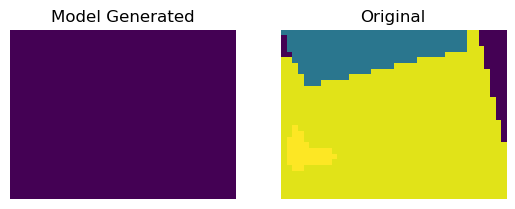

In [21]:
_, _ = compare_masks(dataset, index=0, time_step=0)

Epoch 0:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9204, 0.2718, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1205, time_step: 3


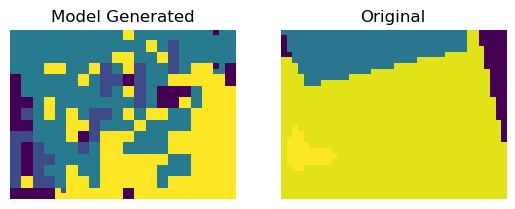

Epoch 1:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9238, 0.2843, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1062, time_step: 2


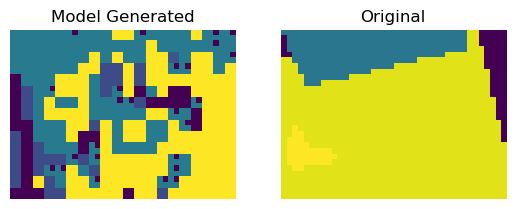

Epoch 2:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9247, 0.2879, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 390, time_step: 7


Epoch 3:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9225, 0.2789, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 2056, time_step: 7


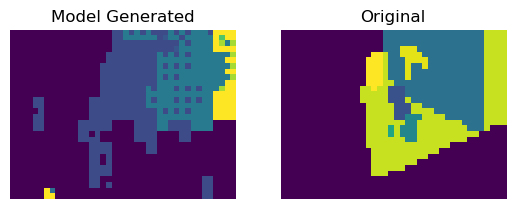

Epoch 4:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9251, 0.2890, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 559, time_step: 2


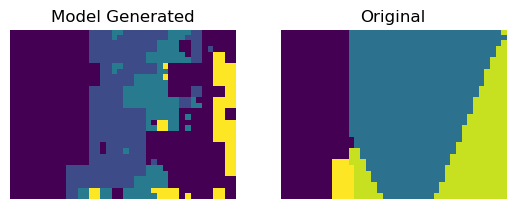

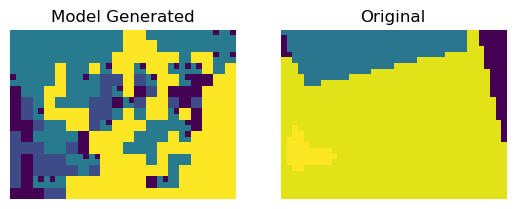

Epoch 5:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9257, 0.2890, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 311, time_step: 0


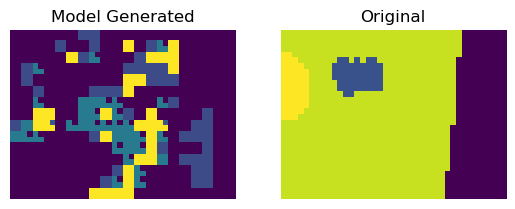

Epoch 6:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9267, 0.2939, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1165, time_step: 4


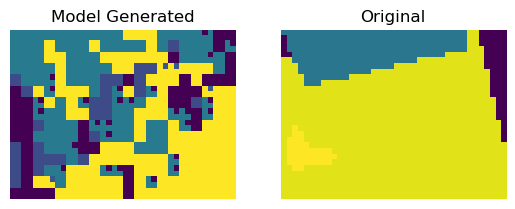

Epoch 7:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9292, 0.3020, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1062, time_step: 0


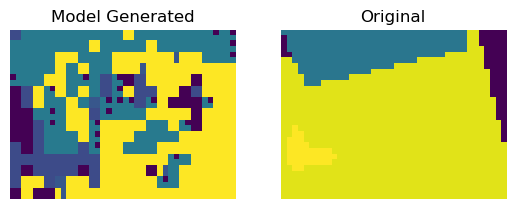

Epoch 8:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9280, 0.2987, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1629, time_step: 6


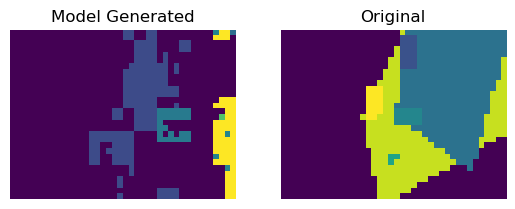

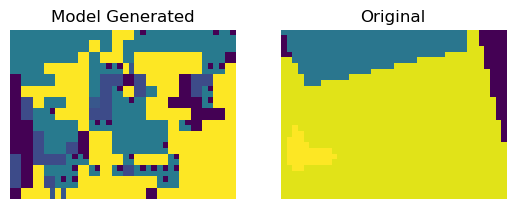

Epoch 9:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9293, 0.3029, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 799, time_step: 4


Epoch 10:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9274, 0.2962, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 798, time_step: 2


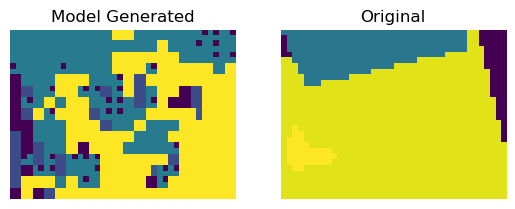

Epoch 11:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9284, 0.3015, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1925, time_step: 5


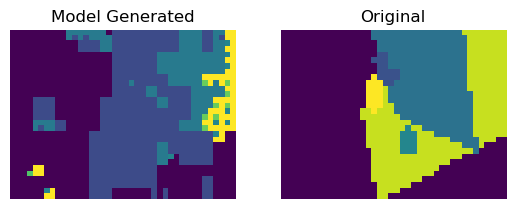

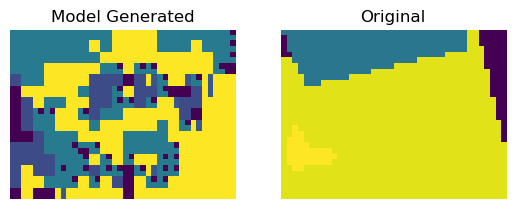

Epoch 12:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9294, 0.3040, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1070, time_step: 1


Epoch 13:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9293, 0.3032, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1489, time_step: 1


Epoch 14:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9305, 0.3076, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 2, time_step: 3


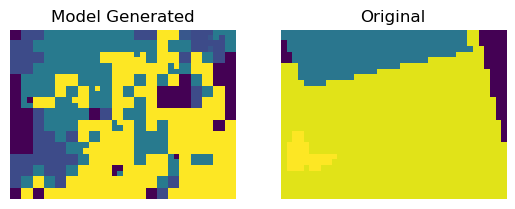

Epoch 15:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9294, 0.3033, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 118, time_step: 2


Epoch 16:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9294, 0.3024, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 2136, time_step: 6


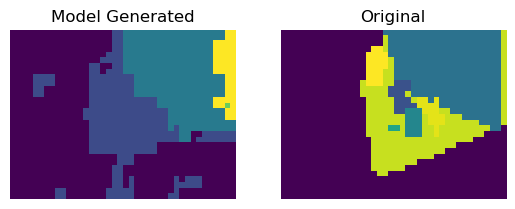

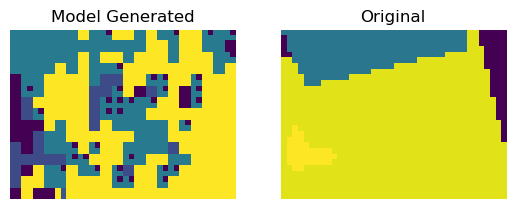

Epoch 17:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9302, 0.3068, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1457, time_step: 7


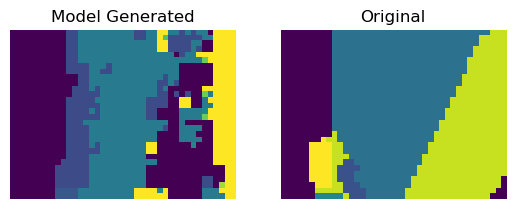

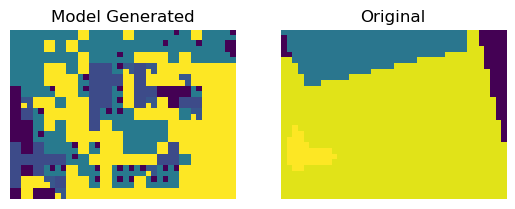

Epoch 18:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9299, 0.3074, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1788, time_step: 6


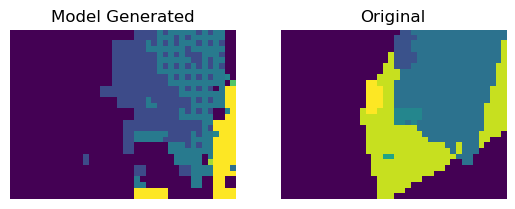

Epoch 19:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9295, 0.3046, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1186, time_step: 6


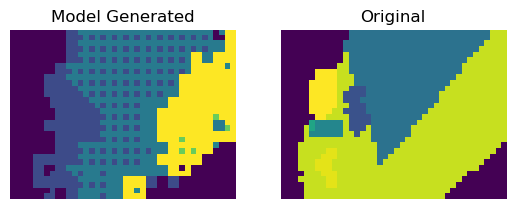

Epoch 20:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9284, 0.3035, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1717, time_step: 2


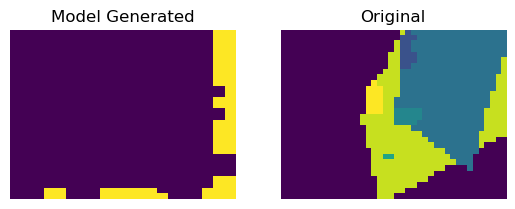

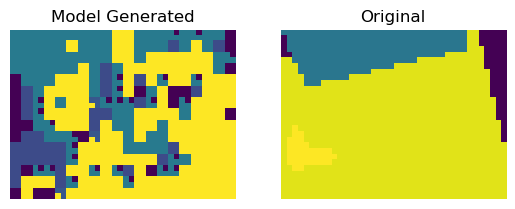

Epoch 21:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9293, 0.3052, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1414, time_step: 2


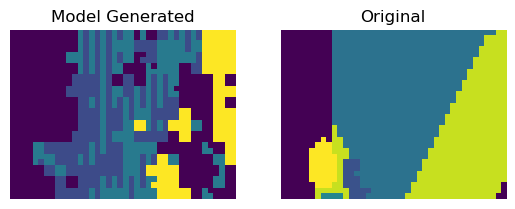

Epoch 22:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9293, 0.3056, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 201, time_step: 2


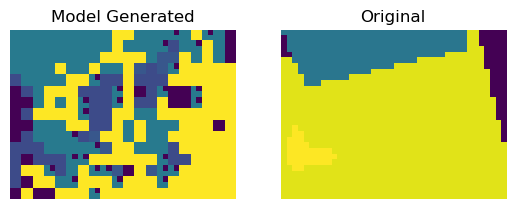

Epoch 23:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9287, 0.3024, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1024, time_step: 0


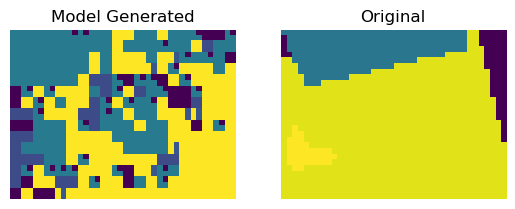

Epoch 24:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9277, 0.2975, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 146, time_step: 2


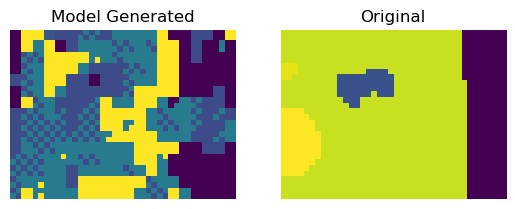

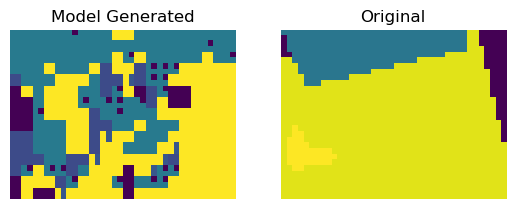

Epoch 25:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9295, 0.3061, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1897, time_step: 1


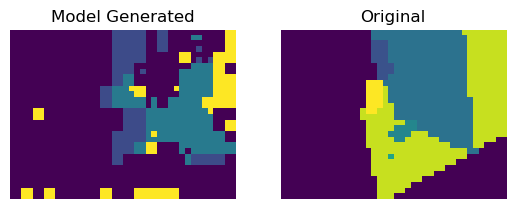

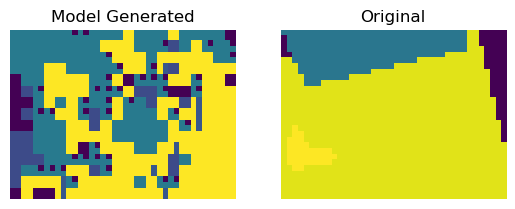

Epoch 26:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9295, 0.3036, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1699, time_step: 4


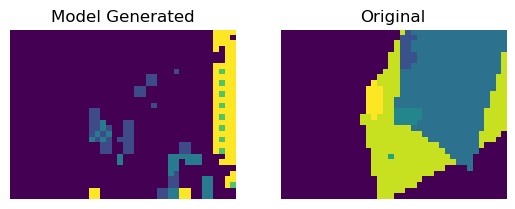

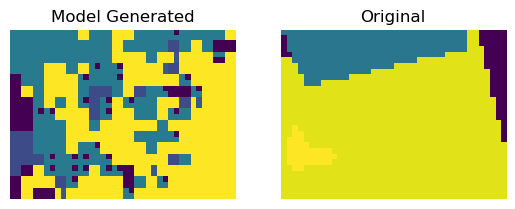

Epoch 27:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9292, 0.3040, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 333, time_step: 2


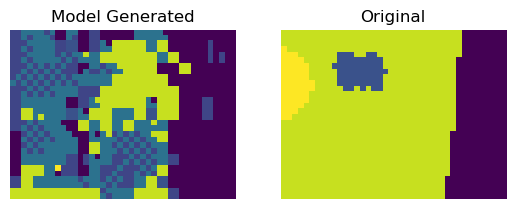

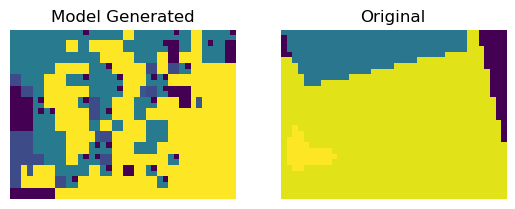

Epoch 28:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9280, 0.2989, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 2013, time_step: 1


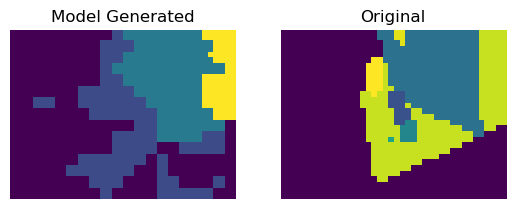

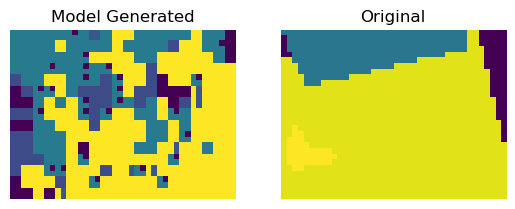

Epoch 29:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9290, 0.3026, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 830, time_step: 2


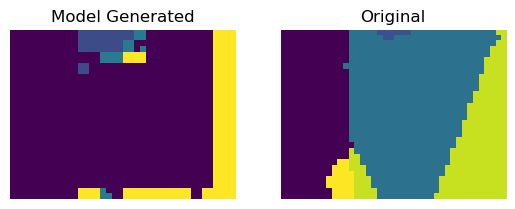

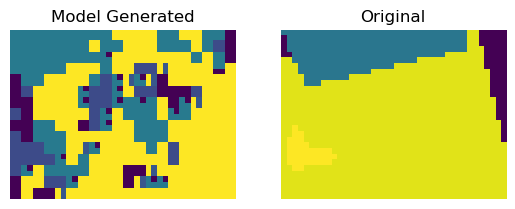

Epoch 30:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9277, 0.2996, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 759, time_step: 0


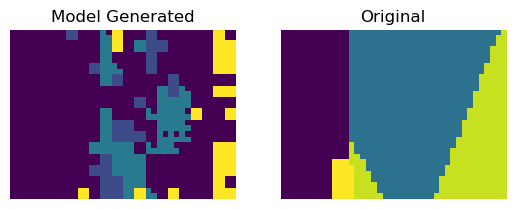

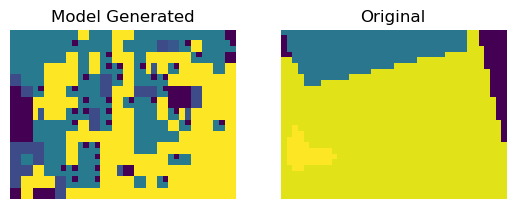

Epoch 31:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9283, 0.3004, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 615, time_step: 0


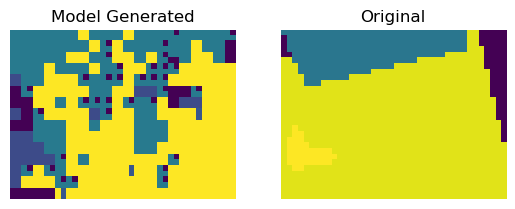

Epoch 32:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9289, 0.3021, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 877, time_step: 6


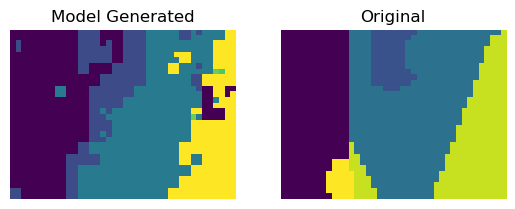

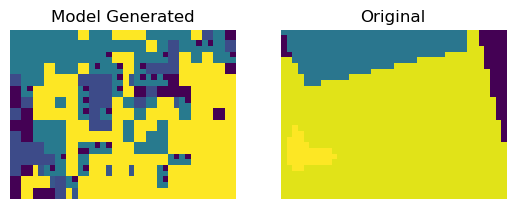

Epoch 33:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9281, 0.2997, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 196, time_step: 0


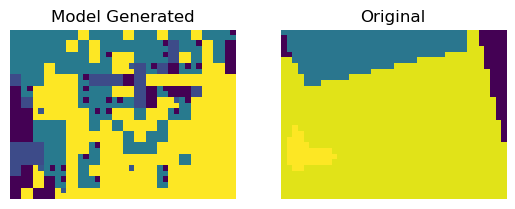

Epoch 34:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9289, 0.3037, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1679, time_step: 7


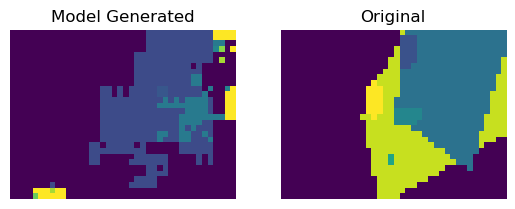

Epoch 35:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9288, 0.3014, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1964, time_step: 4


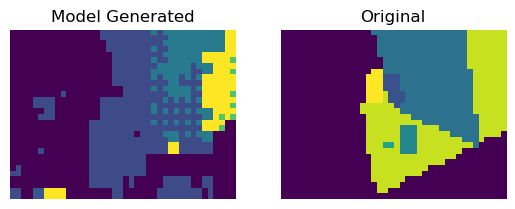

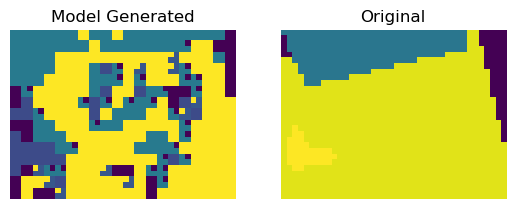

Epoch 36:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9298, 0.3060, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1633, time_step: 0


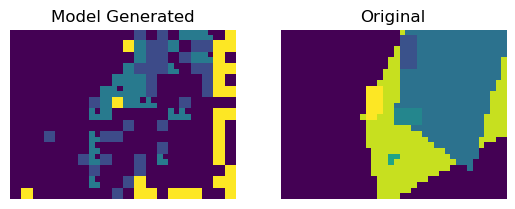

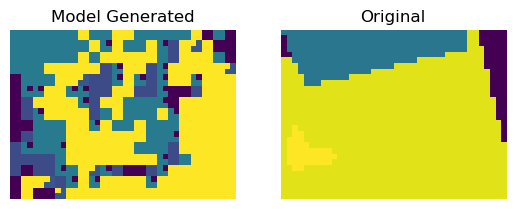

Epoch 37:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9313, 0.3120, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1503, time_step: 7


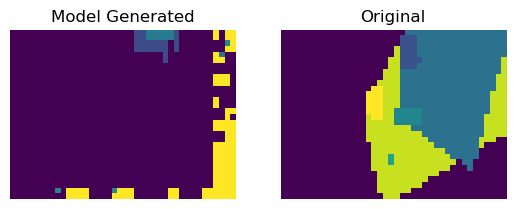

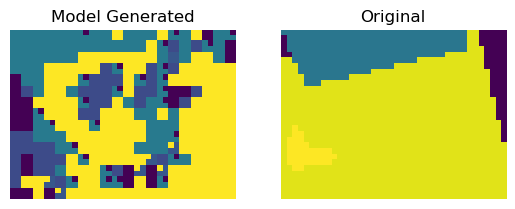

Epoch 38:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9288, 0.3052, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 2038, time_step: 1


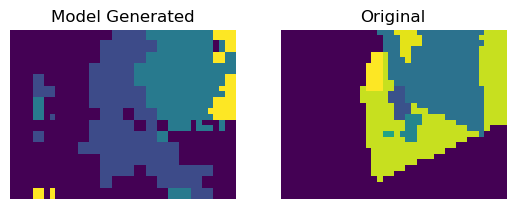

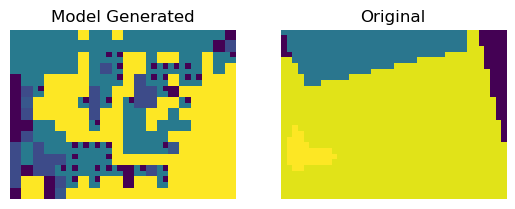

Epoch 39:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9272, 0.2988, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 552, time_step: 2


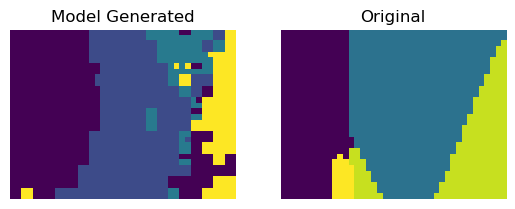

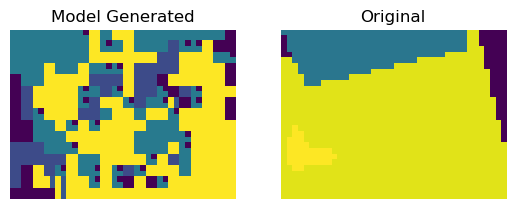

Epoch 40:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9295, 0.3078, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 2111, time_step: 4


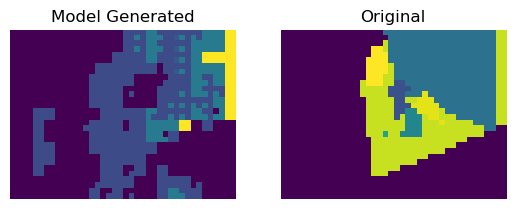

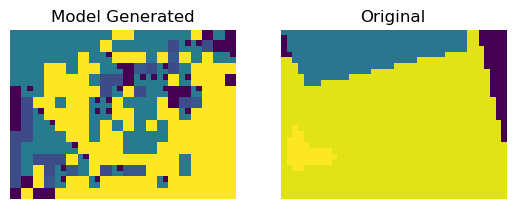

Epoch 41:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9292, 0.3077, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1981, time_step: 2


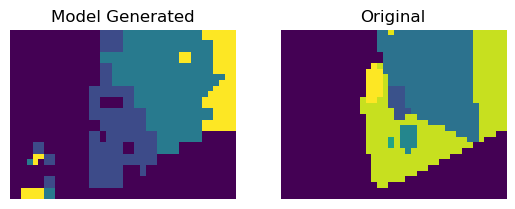

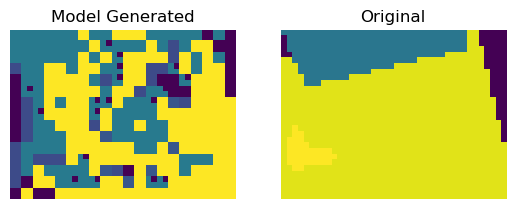

Epoch 42:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9252, 0.2961, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1164, time_step: 2


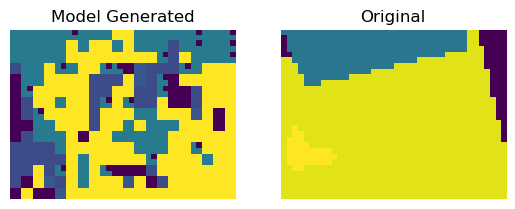

Epoch 43:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9211, 0.2902, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1665, time_step: 7


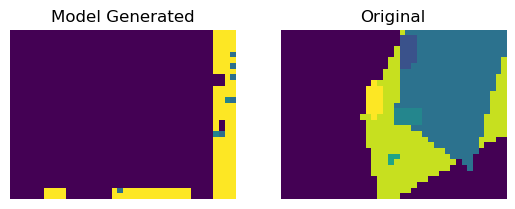

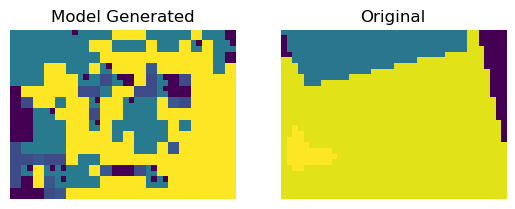

Epoch 44:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9206, 0.2870, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 2168, time_step: 7


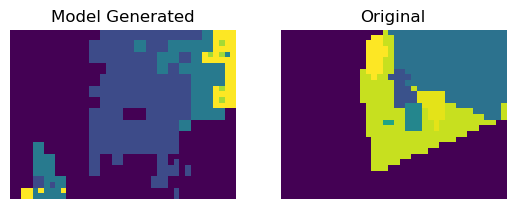

Epoch 45:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9204, 0.2828, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1163, time_step: 6


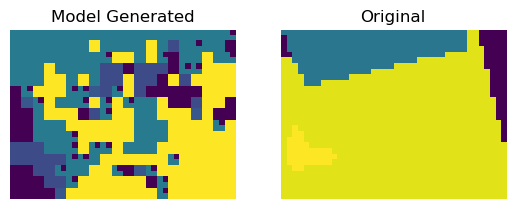

Epoch 46:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9250, 0.2962, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1512, time_step: 3


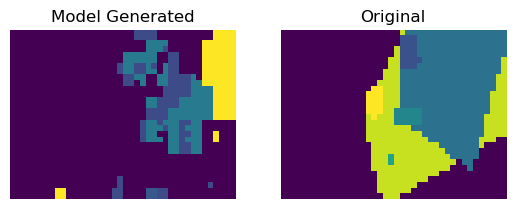

Epoch 47:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9246, 0.2986, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1599, time_step: 5


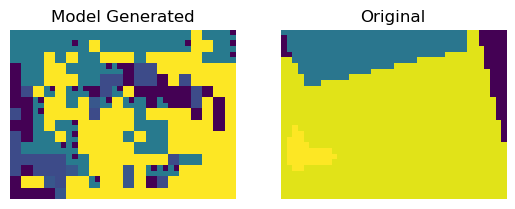

Epoch 48:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9261, 0.3022, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1400, time_step: 1


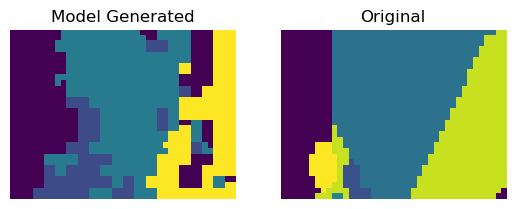

Epoch 49:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9256, 0.3017, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1706, time_step: 0


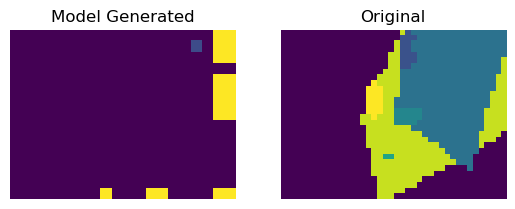

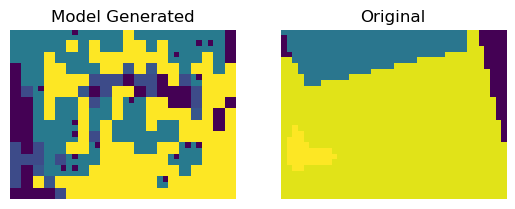

Epoch 50:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9257, 0.3009, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 130, time_step: 7


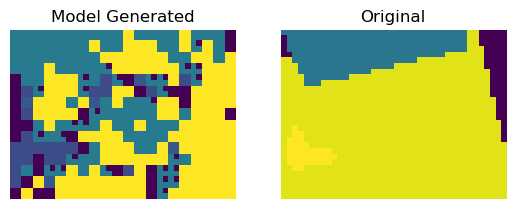

Epoch 51:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9244, 0.2971, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1401, time_step: 5


Epoch 52:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9253, 0.3022, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 250, time_step: 4


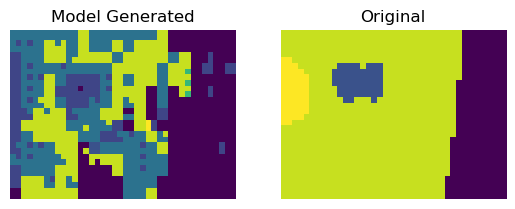

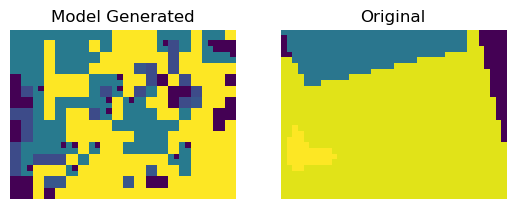

Epoch 53:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9282, 0.3057, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1374, time_step: 2


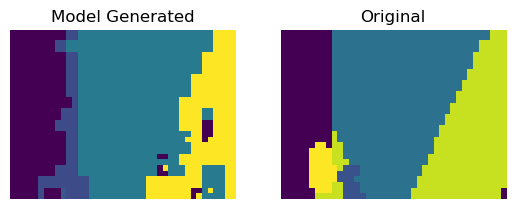

Epoch 54:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9247, 0.2997, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 273, time_step: 4


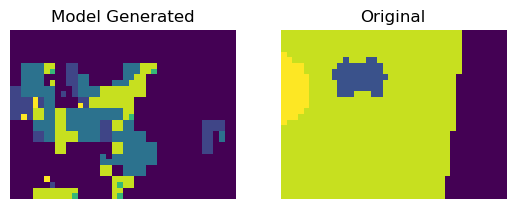

Epoch 55:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9225, 0.2945, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 825, time_step: 3


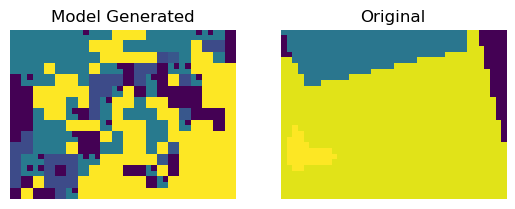

Epoch 56:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9265, 0.3016, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1131, time_step: 7


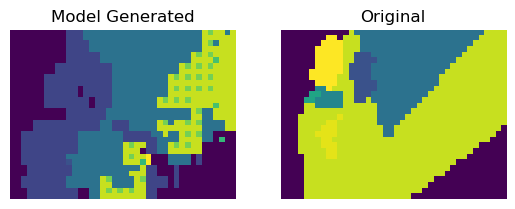

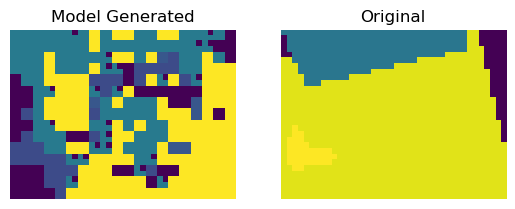

Epoch 57:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9246, 0.2976, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 500, time_step: 5


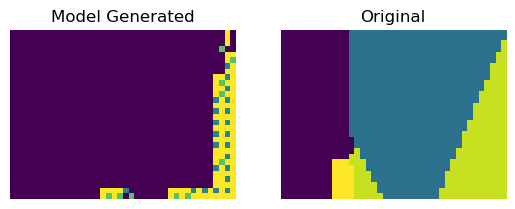

Epoch 58:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9262, 0.3024, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 829, time_step: 4


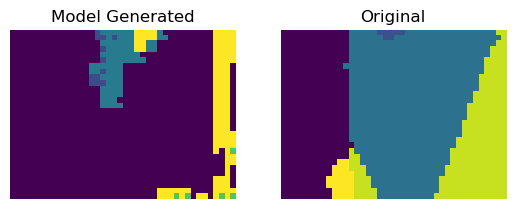

Epoch 59:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9295, 0.3104, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 799, time_step: 4


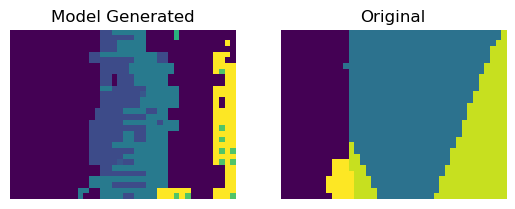

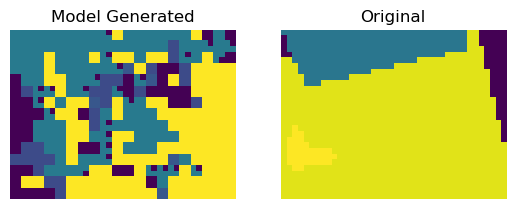

Epoch 60:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9287, 0.3039, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 652, time_step: 0


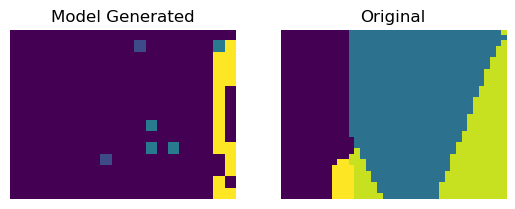

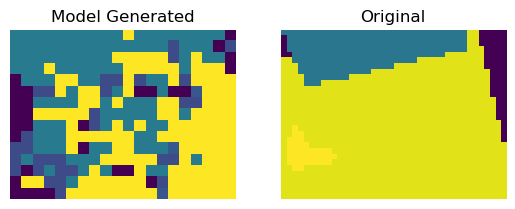

Epoch 61:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9228, 0.2931, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1644, time_step: 4


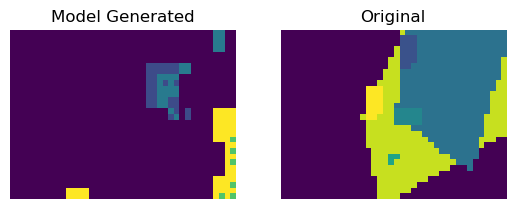

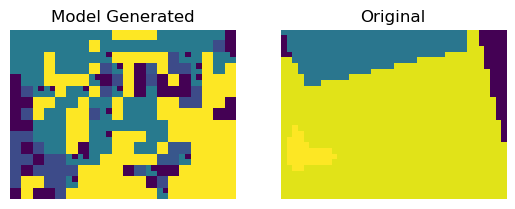

Epoch 62:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9301, 0.3119, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 177, time_step: 4


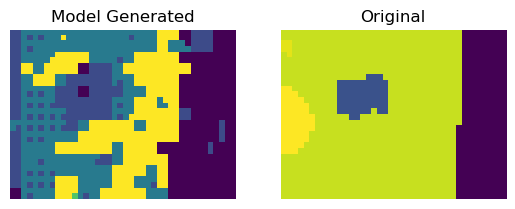

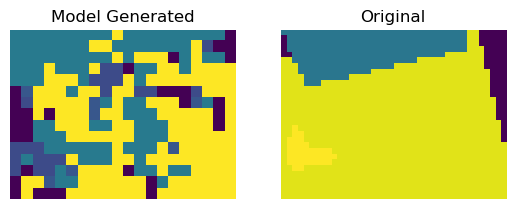

Epoch 63:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9280, 0.3073, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 562, time_step: 0


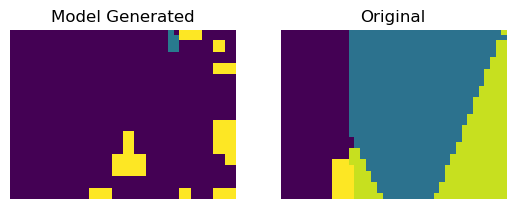

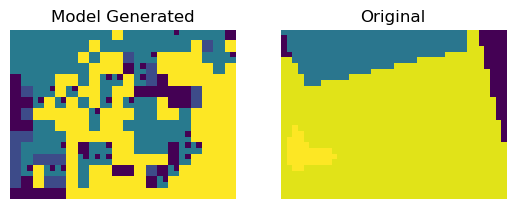

Epoch 64:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9224, 0.2906, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1537, time_step: 1


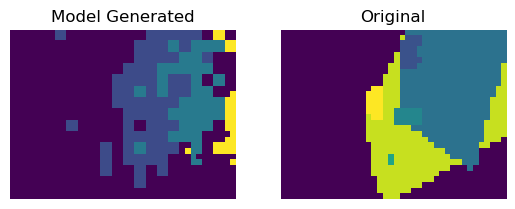

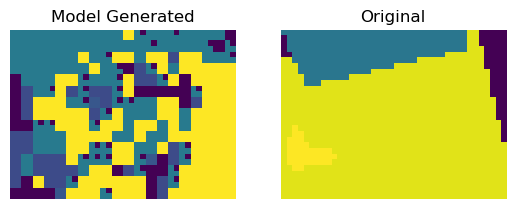

Epoch 65:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9250, 0.3004, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1745, time_step: 0


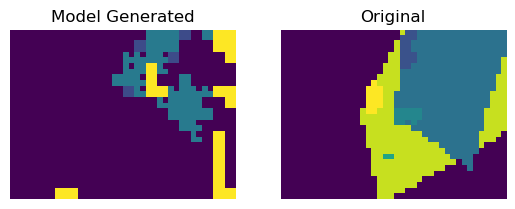

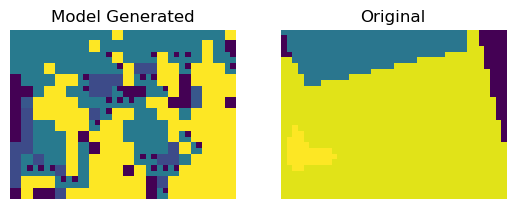

Epoch 66:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9237, 0.2938, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 763, time_step: 3


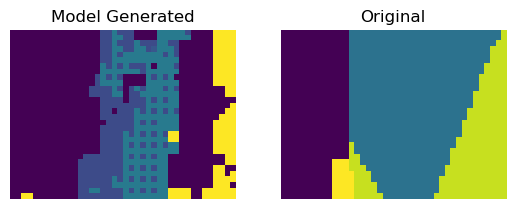

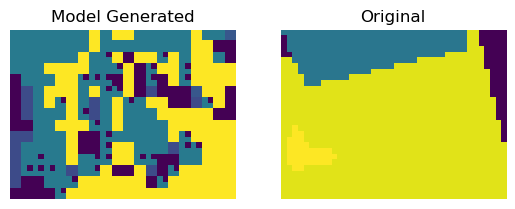

Epoch 67:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9301, 0.3128, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1144, time_step: 6


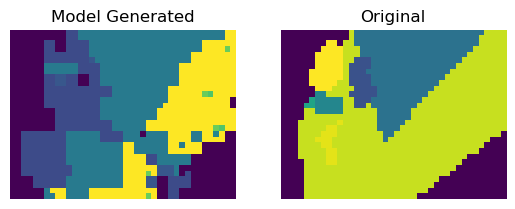

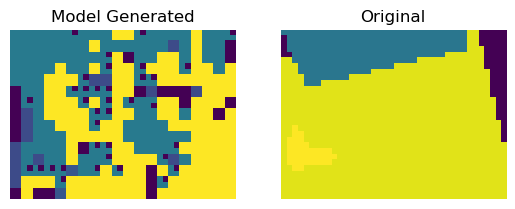

Epoch 68:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9219, 0.2925, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1549, time_step: 0


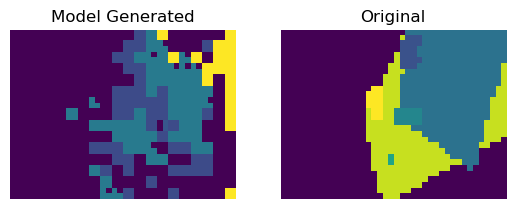

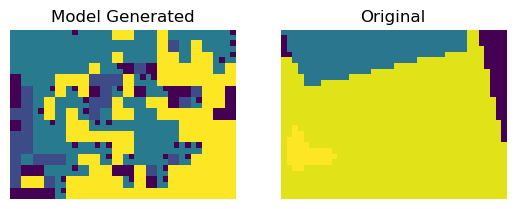

Epoch 69:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9243, 0.2960, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1361, time_step: 2


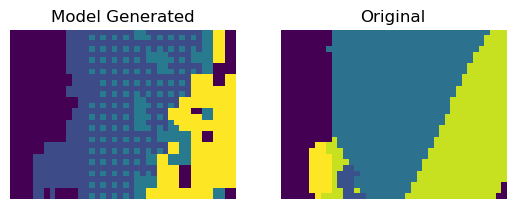

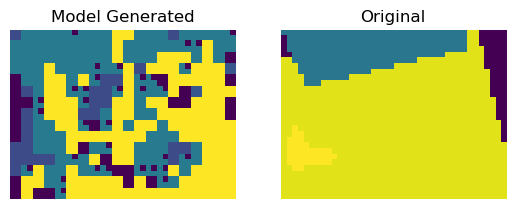

Epoch 70:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9189, 0.2793, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 792, time_step: 7


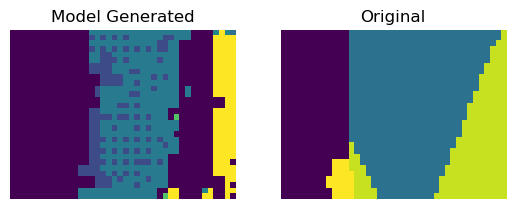

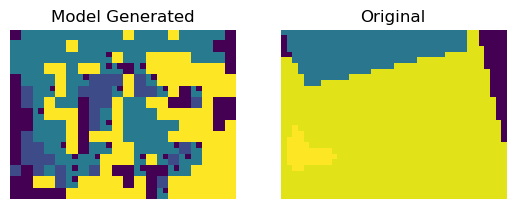

Epoch 71:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9232, 0.2945, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 974, time_step: 7


Epoch 72:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9265, 0.3005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1564, time_step: 1


Epoch 73:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9264, 0.3007, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 556, time_step: 2


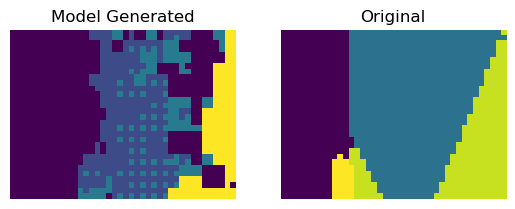

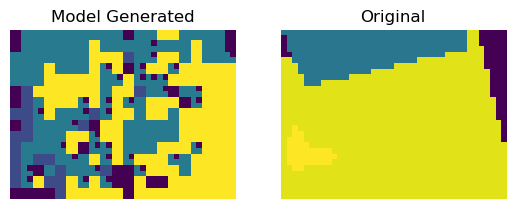

Epoch 74:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9260, 0.2998, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1243, time_step: 0


Epoch 75:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9232, 0.2941, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1873, time_step: 0


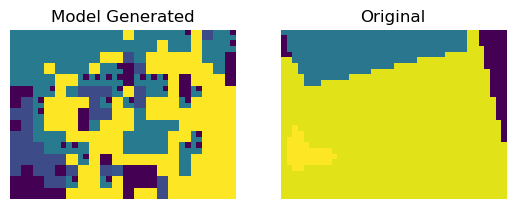

Epoch 76:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9207, 0.2862, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 256, time_step: 3


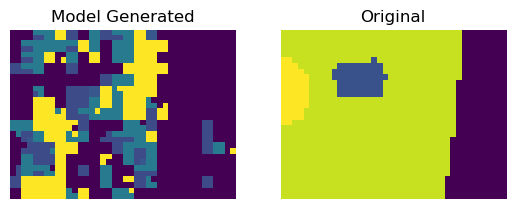

Epoch 77:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9319, 0.3123, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1903, time_step: 3


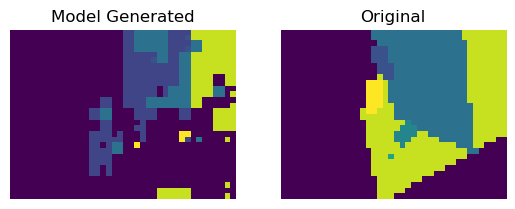

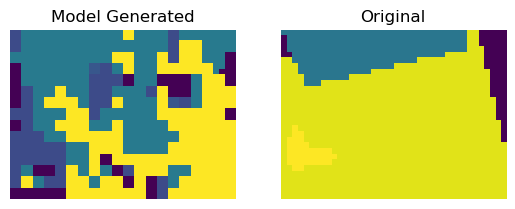

Epoch 78:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9218, 0.2927, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 642, time_step: 0


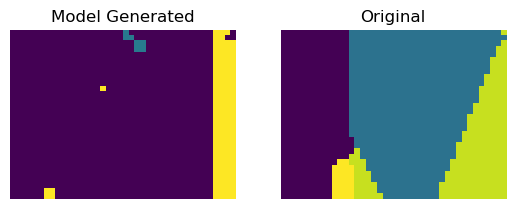

Epoch 79:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9255, 0.2970, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 407, time_step: 6


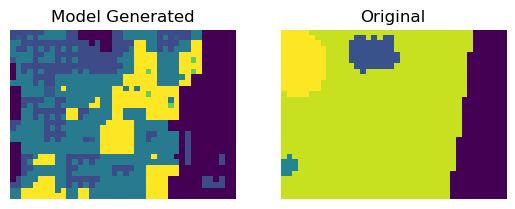

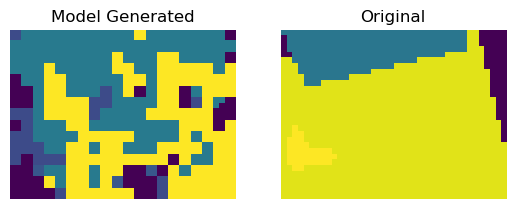

Epoch 80:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9296, 0.3057, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 214, time_step: 3


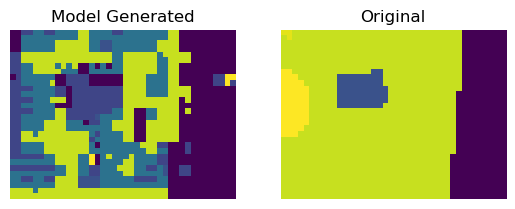

Epoch 81:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9313, 0.3110, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1489, time_step: 3


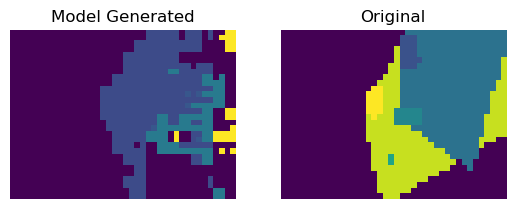

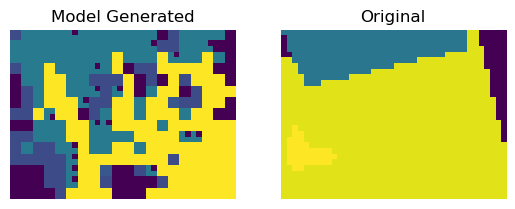

Epoch 82:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9305, 0.3126, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 134, time_step: 3


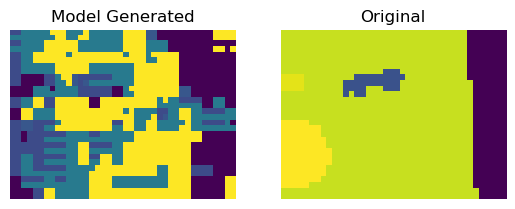

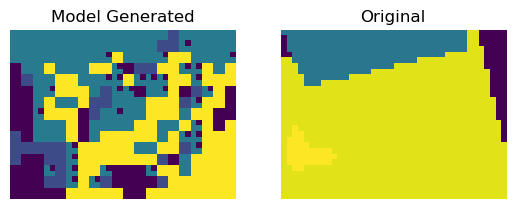

Epoch 83:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9271, 0.3053, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 1484, time_step: 1


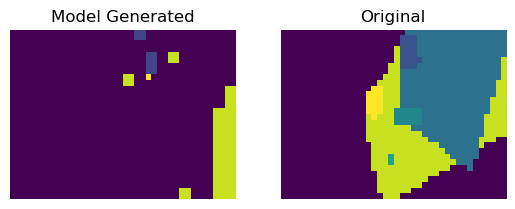

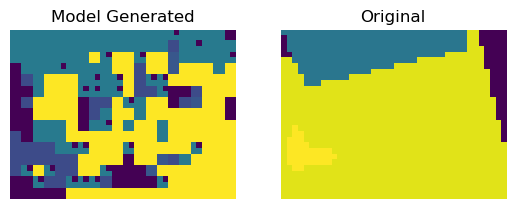

Epoch 84:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9318, 0.3128, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 2071, time_step: 5


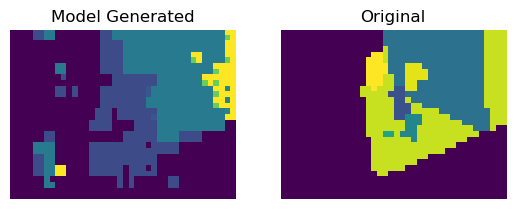

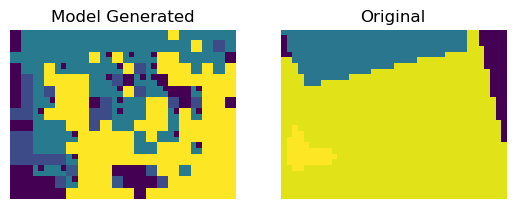

Epoch 85:   0%|          | 0/546 [00:00<?, ?it/s]

Epoch Average IoU Per Class: tensor([0.9327, 0.3195, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
IDX: 513, time_step: 1


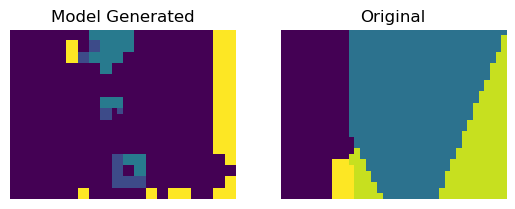

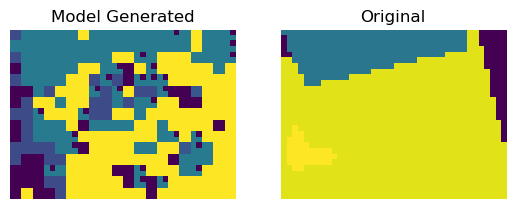

Epoch 86:   0%|          | 0/546 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [32]:
metric = MulticlassJaccardIndex(num_classes=num_classes, average='none').to(device)
for epoch in range(num_epochs):
    train_batch = tqdm(iter(trainloader), desc=f"Epoch {epoch}")

    batch_IoUs = torch.empty((0, ))
    for data, masks in train_batch:
        data = data.to(device).to(torch.float) # Data currently in batch_size, num_steps, Channels, H, W
        masks = masks.to(device)

        model.train()
        spk_rec, mem_rec = model(data)
        
        step_IoUs = torch.empty((0, ))
        # print(mem_rec.shape)
        # print(masks.shape)

        loss_val = loss_fn(spk_rec, masks.to(torch.long))
        for step in range(num_bins_per_frame):
           # loss_val += loss_fn(mem_rec[step], masks.to(torch.long))
            
            preds = spk_rec[step].detach().to(torch.int)
            #print(preds.shape)
            targets = masks.detach().to(torch.int64)

            targets = torch.nn.functional.one_hot(targets, num_classes=num_classes).transpose(1, 3).transpose(2, 3) # IoU metric wants one-hot, while loss does not.

            #print(preds.shape, targets.shape)
            IoU = metric(preds, targets).cpu().unsqueeze(0) # Makes it (1, num_classes) so that it can be catted properly


            step_IoUs = torch.cat((step_IoUs, IoU), dim=0)
        #print(step_IoUs.shape, mean_step_IoUs.shape)
        mean_step_IoUs = torch.mean(step_IoUs, dim=0).unsqueeze(0)
        batch_IoUs = torch.cat((batch_IoUs, mean_step_IoUs), dim=0)
        #print(batch_IoUs.shape)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

    
    mean_batch_IoUs = torch.mean(batch_IoUs, dim=0)
    #print(batch_IoUs.shape, mean_batch_IoUs.shape)
    print(f"Epoch Average IoU Per Class: {mean_batch_IoUs}")
    idx = int(np.random.randint(low=0, high=len(dataset), size=1))
    time_step = int(np.random.randint(low=0, high=num_bins_per_frame, size=1))
    print(f"IDX: {idx}, time_step: {time_step}")
    _, _ = compare_masks(dataset, index=idx, time_step=time_step)
    _, _ = compare_masks(dataset, index=0, time_step=0)

In [33]:
#torch.save(model, "./385epoch_EVIMO_cnn_segmentation.pth")

In [24]:
# for i in range(0, len(dataset)):
#     for timestep in range(0, num_bins_per_frame):
#         out_mask, true_mask = compare_masks(dataset, index=i, time_step=timestep, showonlydiff=True)

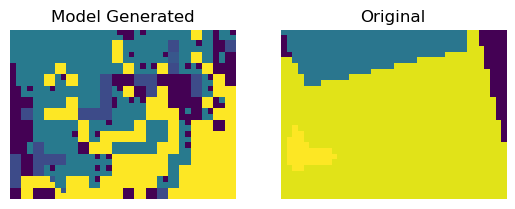

In [25]:
out_mask, true_mask = compare_masks(dataset, index=0, time_step=0)

In [26]:
m = MultilabelJaccardIndex(num_labels=num_classes, average='macro')

In [27]:
test = torch.zeros(1, num_classes, 2, 2) #480, 640)
test2 = torch.zeros(1, num_classes, 2, 2) #, 480, 640)
test.shape

torch.Size([1, 25, 2, 2])

In [28]:
test[0][1][0][0] = 1
test2[0][1][0] = 1
#test2[0][0] = 0

In [29]:
test, test2

(tensor([[[[0., 0.],
           [0., 0.]],
 
          [[1., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.]],
 
          

In [30]:
m(test.to(torch.int), test2.to(torch.int))

tensor(0.0200)